### Model

In [2]:
!pip install split-folders

  Obtaining dependency information for split-folders from https://files.pythonhosted.org/packages/b6/d5/307d63c03356bad6e141d8718d3f4116f51bd9c4b09e2614ffcee1f3c6fd/split_folders-0.5.1-py3-none-any.whl.metadata


In [4]:
!pip install torch

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/3f/14/e105b8ef6d324e789c1589e95cb0ab63f3e07c2216d68b1178b7c21b7d2a/torch-2.2.2-cp311-none-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/b6/53/84a859aaddfe7378a6e5820e864a2d75763e82b6fcbda1a00e92ec620bb7/typing_extensions-4.12.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 4.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.4.2 requires botocore<1.27.60,>=1.27.59, but you have botocore 1.27.96 which is incom

In [6]:
!pip install torchvision

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/46/95/179dd1bf8fd6bd689f0907f4baed557d2b12d2cf3d7ed1a8ecefe0a63d83/torchvision-0.17.2-cp311-cp311-macosx_10_13_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.9 MB/s eta 0:00:0000:0100:01


In [7]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import splitfolders

# Augment images
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image

In [15]:
# access data
DATA_DIR = "/Users/michelle/Library/CloudStorage/OneDrive-SharedLibraries-lmu.edu/Tran, Minh - ML/train/"
img_data = {}

for folder in os.listdir(DATA_DIR):
    img_path = DATA_DIR + folder + '/'
    img_data[folder] = [img_path + img for img in os.listdir(img_path)]

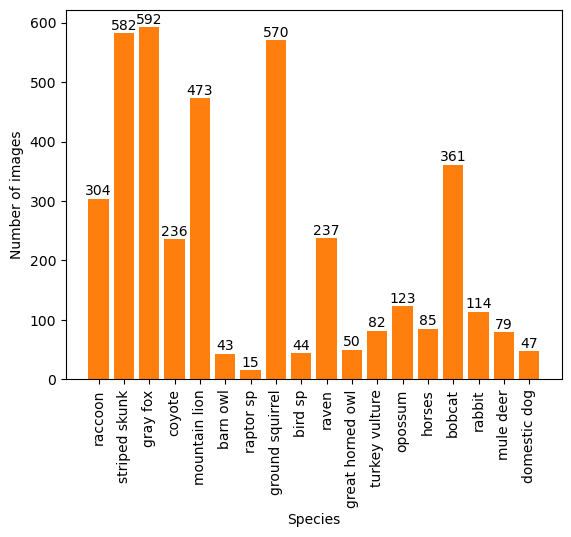

In [23]:
# check class imbalance
num_img = [len(v) for k,v in img_data.items()]
plt.bar(img_data.keys(), num_img)
plt.ylabel('Number of images')
plt.xlabel('Species')
plt.xticks(rotation=90)
# Calculate total number of images in each category
categories = [category for category in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, category))]
category_counts = {category: len(os.listdir(os.path.join(DATA_DIR, category))) for category in categories}
for category, count in category_counts.items():
    plt.text(category, count + 1, str(count), ha='center', va='bottom')

# Plot the bar chart
plt.bar(category_counts.keys(), category_counts.values())
plt.show()

In [24]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from collections import OrderedDict
from datetime import datetime

In [27]:
OUTPUT_DIR = "/Users/michelle/Library/CloudStorage/OneDrive-SharedLibraries-lmu.edu/Tran, Minh - ML/"
img_data = {}

for folder in os.listdir(OUTPUT_DIR):
    subfolder_path = OUTPUT_DIR + folder + '/'
    img_data[folder] = {}
    for subfolder in os.listdir(subfolder_path):
        img_data[folder][subfolder] = len(os.listdir(subfolder_path + subfolder))

df = pd.DataFrame.from_dict(img_data, orient='index')
df.T.plot(kind='bar')

NotADirectoryError: [Errno 20] Not a directory: '/Users/michelle/Library/CloudStorage/OneDrive-SharedLibraries-lmu.edu/Tran, Minh - ML/.DS_Store/'

In [28]:
OUTPUT_DIR = '/Users/michelle/Library/CloudStorage/OneDrive-SharedLibraries-lmu.edu/Tran, Minh - ML/'


In [25]:
# transform images
im_size = 224
transformation = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(im_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])

In [30]:
 # Load data
train_data = datasets.ImageFolder(
    OUTPUT_DIR + "train", transform=transformation
)
val_data = datasets.ImageFolder(
    OUTPUT_DIR + "val", transform=transformation
)
test_data = datasets.ImageFolder(
    OUTPUT_DIR + "test", transform=transformation
)

In [31]:
# Creating data samplers and loaders:
BATCH_SIZE = 20
train_loader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True
)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(
    test_data, batch_size=BATCH_SIZE, shuffle=False
)

In [32]:
# Label mapping
class_mapping = train_data.class_to_idx

In [33]:
def validation(model, criterion, val_loader):
    val_loss = 0
    accuracy = 0

    for images, labels in iter(val_loader):
        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)

        equality = labels.data == probabilities.max(dim=1)[1]
        accuracy += equality.type(torch.FloatTensor).mean()

    return val_loss, accuracy

In [34]:
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=1):
    plot_training = []
    plot_validation = []

    for e in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in iter(train_loader):
            optimizer.zero_grad()

            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Evaluate performance of each epoch
        model.eval()

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            validation_loss, accuracy = validation(model, criterion, val_loader)

        print(
            "Epoch: {}/{}.. ".format(e + 1, epochs),
            "Training Loss: {:.3f}.. ".format(running_loss),
            "Validation Loss: {:.3f}.. ".format(
                validation_loss / len(val_loader)
            ),
            "Validation Accuracy: {:.3f}".format(accuracy / len(val_loader)),
        )

        plot_training.append(running_loss)
        plot_validation.append(validation_loss / len(val_loader))
        
    plt.plot(range(len(plot_training)), plot_training, label='training')
    plt.plot(range(len(plot_validation)), plot_validation, label='validation')
    plt.legend()
    plt.show()

    return model

In [46]:
def save_checkpoint(model, class_mapping, arch):
    """
    Save trained model weights.

    Input:
    arch(str): Model architecture
    """

    checkpoint = {
        "arch": arch,
        "class_to_idx": class_mapping,
        "model_state_dict": model.state_dict(),
    }

    timestamp = datetime.now().date().strftime("%Y%m%d")
    torch.save(checkpoint, f"/Users/michelle/Library/CloudStorage/OneDrive-SharedLibraries-lmu.edu/Tran, Minh - ML/{timestamp}_{arch}.pth")

In [36]:
model = models.resnet50(weights=True)
print(model)

/Users/michelle/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/michelle/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:07<00:00, 13.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [37]:
# Freeze pretrained model parameters to avoid backpropogating through them
for parameter in model.parameters():
    parameter.requires_grad = False

In [38]:
print("Original final layer")
print(model.fc)

# Build custom classifier
num_classes = len(class_mapping)
num_ftrs = model.fc.in_features
classifier = nn.Sequential(
    OrderedDict(
        [
            ("fc", nn.Linear(num_ftrs, num_classes)),
            ("output", nn.LogSoftmax(dim=1)),
        ]
    )
)
model.fc = classifier

print("\nModified final layer")
print(model.fc)

Original final layer
Linear(in_features=2048, out_features=1000, bias=True)

Modified final layer
Sequential(
  (fc): Linear(in_features=2048, out_features=18, bias=True)
  (output): LogSoftmax(dim=1)
)


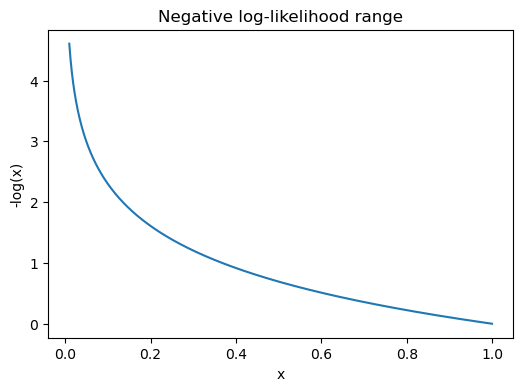

In [39]:
x = np.arange(0.01, 1.0, 0.001)
y = -np.log(x)

fig,ax = plt.subplots(figsize=(6,4))
ax.plot(x,y)
plt.ylabel('-log(x)')
plt.xlabel('x')
plt.title('Negative log-likelihood range')
plt.show()

In [40]:
# Loss function and gradient descent
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

Epoch: 1/1..  Training Loss: 191.443..  Validation Loss: 0.966..  Validation Accuracy: 0.694


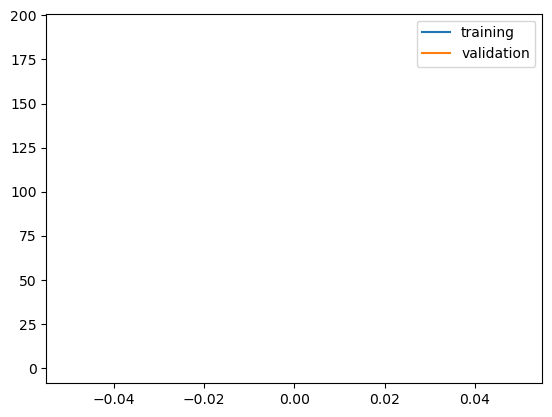

In [42]:
# Train model
resnet_model = train_model(model, optimizer, criterion, train_loader, val_loader)

In [ ]:
# Path to save model
model_path = "

In [ ]:
# Save the model
torch.save(model.state_dict(), model_path)

In [47]:
save_checkpoint(resnet_model, class_mapping, 'resnet50')


In [ ]:
# separate val and test data to reduce overfitting
DATA_DIR = "../img/Dataset/"
OUTPUT_DIR = "../img/output_test/"

splitfolders.fixed(
            DATA_DIR,
            output=OUTPUT_DIR,
            seed=1337,
            fixed=(20, 20),
        )